Estimated position: (4.8983963890055895, 2.410116655144811)


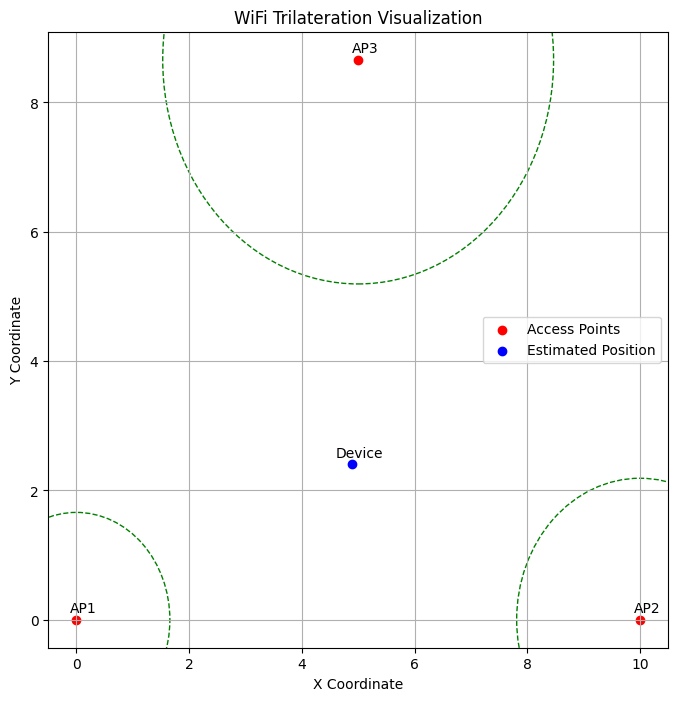

In [23]:
import re
import subprocess
from math import pow, sqrt
import matplotlib.pyplot as plt

def read_data_from_cmd2():
    p = subprocess.Popen("netsh wlan show networks mode=bssid", stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out = p.stdout.read().decode('unicode_escape').strip()
    p.communicate() 
    return out

def get_signal_strength(SSID):
    data = read_data_from_cmd2()
    list1 = re.findall(r'SSID \d+ : (.*?)\n.*?Signal\s+:\s+(\d+)%', data, re.DOTALL)
    
    for i in list1:
        if i[0].strip() == SSID:
            return int(i[1])  # Return signal strength as integer
    return None

def calculate_distance_wifi(signal_strength):
    if(signal_strength <= 0):
         rssi = -100;
    elif(signal_strength >= 100):
        rssi = -50;
    else:
         rssi = signal_strength * 0.5 - 100;
    # Convert signal strength percentage to approximate RSSI in dBm
   # rssi = -90 + (signal_strength * 0.6)  # Adjust this formula if needed
    measured_power = -45  # Reference power level at 1 meter (typical range is -40 to -50 dBm)
    n = 2.5             # Path-loss exponent (adjustable based on the environment)
    
    # Calculate distance using the formula
    distance = pow(10, (measured_power - rssi) / (10 * n))
    
    return distance

def trilaterate(position1, distance1, position2, distance2, position3, distance3):
    # Positions (x1, y1), (x2, y2), (x3, y3) of APs and distances to device
    x1, y1 = position1
    x2, y2 = position2
    x3, y3 = position3

    # Solve for x, y using trilateration formulas
    A = 2 * (x2 - x1)
    B = 2 * (y2 - y1)
    C = distance1**2 - distance2**2 - x1**2 + x2**2 - y1**2 + y2**2
    D = 2 * (x3 - x2)
    E = 2 * (y3 - y2)
    F = distance2**2 - distance3**2 - x2**2 + x3**2 - y2**2 + y3**2

    # Solve for x and y
    x = (C * E - F * B) / (A * E - B * D)
    y = (C * D - A * F) / (B * D - A * E)
    
    return (x, y)

# Define AP information
access_points = {
    'AP1': {'ssid': 'Ooredoo 4G_8A7073', 'position': (0, 0)},
    'AP2': {'ssid': 'Rouee', 'position': (10, 0)},
    'AP3': {'ssid': 'NONE', 'position': (5, 8.66)}  # Roughly an equilateral triangle
}

# Retrieve signal strengths and calculate distances
distances = {}
for ap_name, ap_info in access_points.items():
    signal_strength = get_signal_strength(ap_info['ssid'])
    if signal_strength is not None:
        distances[ap_name] = calculate_distance_wifi(signal_strength)
    else:
        print(f"SSID '{ap_info['ssid']}' not found.")

# Ensure we have distances from all three APs
if len(distances) == 3:
    pos1 = access_points['AP1']['position']
    pos2 = access_points['AP2']['position']
    pos3 = access_points['AP3']['position']
    
    distance1 = distances['AP1']
    distance2 = distances['AP2']
    distance3 = distances['AP3']

    # Perform trilateration
    estimated_position = trilaterate(pos1, distance1, pos2, distance2, pos3, distance3)
    print(f"Estimated position: {estimated_position}")
     # Plotting the APs and estimated position
    plt.figure(figsize=(8, 8))
    plt.scatter(*zip(*[pos1, pos2, pos3]), c='red', label='Access Points')
    plt.scatter(*estimated_position, c='blue', label='Estimated Position')
    plt.annotate('AP1', pos1, textcoords="offset points", xytext=(5, 5), ha='center')
    plt.annotate('AP2', pos2, textcoords="offset points", xytext=(5, 5), ha='center')
    plt.annotate('AP3', pos3, textcoords="offset points", xytext=(5, 5), ha='center')
    plt.annotate('Device', estimated_position, textcoords="offset points", xytext=(5, 5), ha='center')

    # Plotting circles representing the distances
    for pos, dist in zip([pos1, pos2, pos3], [distance1, distance2, distance3]):
        circle = plt.Circle(pos, dist, color='green', fill=False, linestyle='dashed')
        plt.gca().add_artist(circle)

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('WiFi Trilateration Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Could not determine distances from all access points.")
